In [ ]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
import csv

#import cv2

from PIL import Image
from PIL import ImageFilter



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [28]:


### PREPROCESS IN PYTORCH

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3418, 0.3126, 0.3224], std=[0.1627, 0.1632, 0.1731])
])



In [3]:
!git clone https://github.com/yuyecreus/CNN-in-mobile-device

Cloning into 'CNN-in-mobile-device'...
remote: Enumerating objects: 258524, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 258524 (delta 17), reused 27 (delta 9), pack-reused 258472
Receiving objects: 100% (258524/258524), 2.07 GiB | 22.63 MiB/s, done.
Resolving deltas: 100% (79335/79335), done.
Checking out files: 100% (61207/61207), done.


In [4]:
!ls

CNN-in-mobile-device  sample_data


In [29]:
#trainset = torchvision.datasets.ImageFolder("GTSRB/Training", transform = preprocess)
trainset = torchvision.datasets.ImageFolder("CNN-in-mobile-device/data/raw/TRAIN", transform = preprocess)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=False)

In [17]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [33]:
print(len(trainset))
size=256

39208


In [31]:
testset = torchvision.datasets.ImageFolder("CNN-in-mobile-device/data/raw/TEST", transform = preprocess)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, drop_last=True)

In [47]:
len(testset)
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 256, 256])
Shape of y:  torch.Size([64]) torch.int64


In [34]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(size*size*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 43),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=196608, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=43, bias=True)
    (5): ReLU()
  )
)


In [11]:
## To train a model, we need a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
#In a single training loop, the model makes predictions on the training dataset 
#(fed to it in batches), and backpropagates the prediction
# error to adjust the model’s parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
# We also check the model’s performance against the test dataset to ensure it is learning.
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [35]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 3.771826  [    0/39208]
loss: 3.753144  [ 6400/39208]
loss: 3.760105  [12800/39208]
loss: 3.773008  [19200/39208]
loss: 3.746711  [25600/39208]
loss: 3.749993  [32000/39208]
loss: 3.768960  [38400/39208]
Test Error: 
 Accuracy: 2.0%, Avg loss: 0.058708 

Epoch 2
-------------------------------
loss: 3.740940  [    0/39208]
loss: 3.762645  [ 6400/39208]
loss: 3.777779  [12800/39208]
loss: 3.758851  [19200/39208]
loss: 3.772601  [25600/39208]
loss: 3.771761  [32000/39208]
loss: 3.757644  [38400/39208]
Test Error: 
 Accuracy: 2.0%, Avg loss: 0.058709 

Epoch 3
-------------------------------
loss: 3.770159  [    0/39208]
loss: 3.764560  [ 6400/39208]
loss: 3.768163  [12800/39208]
loss: 3.765164  [19200/39208]
loss: 3.751786  [25600/39208]
loss: 3.752835  [32000/39208]
loss: 3.760560  [38400/39208]
Test Error: 
 Accuracy: 2.0%, Avg loss: 0.058708 

Done!


In [ ]:
# Saving model
# Saving model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

262144

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

28.0

In [69]:
classes2 = list(range(43))
print(classes2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [74]:
# Using the model to make predictions
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = testset[400][0], torch.tensor(testset[400][1])
print(testset[0][0], testset[0][1])
print(type(testset[0][0]))
print(type(torch.tensor(testset[0][1])))

print(x.shape)

#trial = torch.FloatTensor(1,3,256,256).to(device)


#x, y = testset[0][0].to(device), testset[0][1].to(device)

x = x.to(device)
y = y.to(device)

x = torch.reshape(x, (1,3,256, 256))
#x,y = torch.FloatTensor(1,3,256,256).to(device)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes2[pred[0].argmax(0)], classes2[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([[[ 4.0455,  4.0455,  4.0455,  ..., -0.8474, -0.8474, -0.8474],
         [ 4.0455,  4.0455,  4.0455,  ..., -0.8474, -0.8474, -0.8474],
         [ 4.0455,  4.0455,  4.0455,  ..., -0.8474, -0.8474, -0.8474],
         ...,
         [-0.4618, -0.4618, -0.4618,  ..., -1.2331, -1.2331, -1.2331],
         [-0.4618, -0.4618, -0.4618,  ..., -1.2331, -1.2331, -1.2331],
         [-0.4618, -0.4618, -0.4618,  ..., -1.2331, -1.2331, -1.2331]],

        [[ 3.4911,  3.4911,  3.4911,  ..., -1.4829, -1.4829, -1.4829],
         [ 3.4911,  3.4911,  3.4911,  ..., -1.4829, -1.4829, -1.4829],
         [ 3.4911,  3.4911,  3.4911,  ..., -1.4829, -1.4829, -1.4829],
         ...,
         [ 0.4875,  0.4875,  0.4875,  ..., -1.1946, -1.1946, -1.1946],
         [ 0.4875,  0.4875,  0.4875,  ..., -1.1946, -1.1946, -1.1946],
         [ 0.4875,  0.4875,  0.4875,  ..., -1.1946, -1.1946, -1.1946]],

        [[ 2.3060,  2.3060,  2.3060,  ..., -1.4094, -1.4094, -1.4094],
         [ 2.3060,  2.3060,  2.3060,  ..., -1

In [63]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install cv2

     |████████████████████████████████| 50.4MB 60kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


torch.Size([3, 256, 256])
<class 'torch.Tensor'>


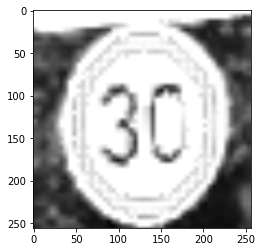

Label:


In [73]:
# Display image and label.
#train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = trainset[400][0].squeeze()
#label = train_labels[0]
print(img.shape)
# Changing to gray scale
images = img[0,:,:] 
images = images.unsqueeze(0) #https://stackoverflow.com/questions/52439364/how-to-convert-rgb-images-to-grayscale-in-pytorch-dataloader
print(type(images))
images = images.squeeze()
plt.imshow(images, cmap="gray")
plt.show()
print(f"Label:")

In [59]:
x, y = testset[0][0], torch.tensor(testset[0][1])

tensor([[[-0.2931, -0.2931, -0.2931,  ..., -0.5100, -0.5100, -0.5100],
         [-0.2690, -0.2690, -0.2690,  ..., -0.4618, -0.4618, -0.4618],
         [-0.2449, -0.2449, -0.2449,  ..., -0.4377, -0.4377, -0.4377],
         ...,
         [-0.0279, -0.0279, -0.0279,  ...,  0.0926,  0.0926,  0.0926],
         [-0.0279, -0.0279, -0.0279,  ...,  0.0926,  0.0926,  0.0926],
         [-0.0520, -0.0520, -0.0520,  ...,  0.0685,  0.0685,  0.0685]],

        [[-0.0412, -0.0412, -0.0412,  ..., -0.3055, -0.3055, -0.3055],
         [-0.0171, -0.0171, -0.0171,  ..., -0.2574, -0.2574, -0.2574],
         [-0.0171, -0.0171, -0.0171,  ..., -0.2334, -0.2334, -0.2334],
         ...,
         [ 0.1751,  0.1751,  0.1751,  ...,  0.4635,  0.4635,  0.4635],
         [ 0.1270,  0.1270,  0.1270,  ...,  0.4394,  0.4394,  0.4394],
         [ 0.1030,  0.1030,  0.1030,  ...,  0.4154,  0.4154,  0.4154]],

        [[-0.0501, -0.0501, -0.0501,  ..., -0.3673, -0.3673, -0.3673],
         [-0.0275, -0.0275, -0.0275,  ..., -0